# Generate cutting XML from exported results from QUPath

The stitched images were loaded into Qupath and specific regions annotaed by hand. calibration points were also selected and labelled with `calib1`, `calib2` and `calib3`.

![QuPath manual shape annotation](./test_data/cellculture_example/qupath_annotation.png "Qupath Manual shape annotation")

The annotated shapes were then exported to geojson file.

![Geojson export](./test_data/cellculture_example/qupath_export_1.png "GEOjson export")
![Geojson export](./test_data/cellculture_example/geojson_export_2.png "GEOjson export")


## Import libraries and define helper functions

In [11]:
import shapely
import geopandas
import pandas as pd
import numpy as np

from lmd.lib import Collection

In [12]:
def separate_points_polygons(df: geopandas.GeoDataFrame, geometry_column: str = "geometry") -> tuple[geopandas.GeoDataFrame, geopandas.GeoDataFrame]:
    """Split QuPath geopandas dataframe by shape types"""
    points = df[geometry_column].apply(lambda geom: isinstance(geom, shapely.Point))
    polygons = df[geometry_column].apply(lambda geom: isinstance(geom, shapely.Polygon))

    return df.loc[points], df.loc[polygons]

In [ ]:
def get_calib_points(list_of_calibpoint_names: str, df: geopandas.GeoDataFrame) -> np.ndarray:
    """Parse selected points into np.array"""

    #Create list of relevant shapes
    pointlist = []
    for point_name in list_of_calibpoint_names:
        pointlist.append(df.loc[df['name'] == point_name, 'geometry'].values[0])
    
    return np.array([[point.x, point.y] for point in pointlist])

## Import GEOjson regions

The geojson dataset is loaded into a dataframe with the following structure:

id | objectType  | classification | name | geometry |
--- | --- | --- | --- | --- 
unique shape id  |  type of shape (e.g. annotation)  |    all annotation information from qupath    |  shape name if given      |  contains information relevant for shape

The geojson should besides containing individual segemnted shapes contain 3 points annotated as calib1, calib2, calib3 that will be used as calibration points for generating the XML

In [ ]:
df = geopandas.read_file("test_data/cellculture_example/annotated_regions_Qupath.geojson")
df

Skipping field color: unsupported OGR type: 1


,id,objectType,name,geometry
0,9287277d-e46f-47e9-aa3f-c540b3318b5e,annotation,region2,"POLYGON ((507 1524, 506.6 1539.01, 505.39 1553..."
1,ab63cfd3-17d0-4dd3-b8e6-95172dda64de,annotation,Region1,"POLYGON ((1789 990, 1730 1153, 1744 1467, 1944..."
2,b60d2cf7-963e-42ae-8a2a-69ff289d29db,annotation,calib1,POINT (343.24 368.53)
3,56bdd076-ac9a-4950-97f3-b8c2268ee090,annotation,calib3,POINT (361.78 2301.51)
4,03d9bb6e-16b1-4cd9-9181-86da90fb98bf,annotation,calib2,POINT (1353.77 1165.83)


Annotations and calibration points (`shapely.Point` objects) and annoatations (`shapely.Polygon` objects) should be processed separately. Therefore, we will use the previously defined helper function `separate_points_polygons` to split the dataframe by shape type.

In [31]:
# Separate calibration points (shapely.Points) from annotations (shapely.Polygons)
points, annotations = separate_points_polygons(df)

Let's inspect the separated geodataframes

In [32]:
points

,id,objectType,name,geometry
2,b60d2cf7-963e-42ae-8a2a-69ff289d29db,annotation,calib1,POINT (343.24 368.53)
3,56bdd076-ac9a-4950-97f3-b8c2268ee090,annotation,calib3,POINT (361.78 2301.51)
4,03d9bb6e-16b1-4cd9-9181-86da90fb98bf,annotation,calib2,POINT (1353.77 1165.83)


In [33]:
annotations

,id,objectType,name,geometry
0,9287277d-e46f-47e9-aa3f-c540b3318b5e,annotation,region2,"POLYGON ((507 1524, 506.6 1539.01, 505.39 1553..."
1,ab63cfd3-17d0-4dd3-b8e6-95172dda64de,annotation,Region1,"POLYGON ((1789 990, 1730 1153, 1744 1467, 1944..."


## Calibration points

pyLMD expects calibration points as numpy array of the shape (N, 2). We therefore need to extract the coordinates of the calibration points from the `points` geodataframe. To do so, we will use the second helper function `get_calib_points` that converts the `geometry` column of the selected points to a numpy array. Each row in the numpy array represents the coordinates of the calibration points in (x, y) format. 

In [ ]:
caliblist = get_calib_points(['calib1','calib2','calib3'], points)
caliblist

array([[ 343.24,  368.53],
       [1353.77, 1165.83],
       [ 361.78, 2301.51]])

## Generate shape collection

We are now able to convert the annotation dataframe to a collection of shapes. To do so, we initialize an empty pylmd `Collection` with the previously defined calibration points. We will further define the flip the axes of the points with an `orientation_transform` as the image coordinates are flipped compared to the microscope coordinates (for a detailed explanation see [this tutorial](https://mannlabs.github.io/py-lmd/html/pages/segmentation_loader.html#different-coordinate-systems))

In [29]:
orientation_transform = np.array(
    [
        [1, 0], 
        [0, -1]
    ]
)

shape_collection = Collection(
    calibration_points=caliblist,
    orientation_transform=orientation_transform
    )

# Load geopandas into collection class 
shape_collection.load_geopandas(annotations)

shape_collection.stats()

===== Collection Stats =====
Number of shapes: 2
Number of vertices: 117
Mean vertices: 58
Min vertices: 16
5% percentile vertices: 20
Median vertices: 58
95% percentile vertices: 97
Max vertices: 101


Let's inspect the loaded annotations and calibration points with the internal `plot` function:

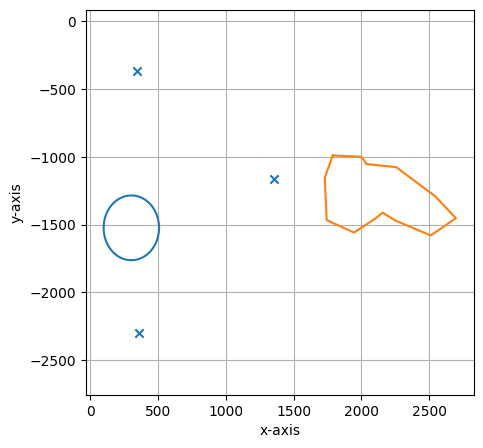

In [ ]:
shape_collection.plot(calibration = True)

## Write to XML

You can now write the selection to a Leica-compatible xml file

In [ ]:
shape_collection.save("./test_data/cellculture_example/shapes_2.xml")